MODEL LOADING

In [ ]:
# --- BAGIAN 1: PERSIAPAN ALAT & MODEL (RUN SEKALI SAJA) ---
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from google.colab import drive
import IPython.display as ipd
from google.colab import files

# 1. Sambungkan Drive
drive.mount('/content/drive')

# 2. Definisikan Arsitektur Model (Kerangka Tubuh)
def build_flexible_model():
    inputs = layers.Input(shape=(None, 257)) # Input fleksibel
    x = layers.LSTM(256, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.TimeDistributed(layers.Dense(257, activation='relu'))(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# 3. Load Model & Weights
print("🔄 Sedang memuat model...")
flexible_model = build_flexible_model()

# --- GANTI PATH INI SESUAI LOKASI FILE .h5 DI DRIVE KAMU ---
model_path = '/content/drive/MyDrive/datasetrnn1/MODEL_JADI_LSTM.h5'

if os.path.exists(model_path):
    flexible_model.load_weights(model_path)
    print("✅ SUKSES! Model berhasil dimuat dan siap digunakan.")
else:
    print("❌ ERROR: File model tidak ditemukan di path tersebut.")
    print("👉 Cek lagi letak file .h5 di Google Drive kamu.")

# 4. Fungsi Pembersih Suara (Inference)
def denoise_audio(audio_path):
    # Load (Resample ke 16k)
    y, sr = librosa.load(audio_path, sr=16000)

    # Preprocess (STFT)
    S = librosa.stft(y, n_fft=512, hop_length=256)
    S_mag = np.abs(S).T
    S_phase = np.angle(S)

    # Predict
    X_input = np.expand_dims(S_mag, axis=0)
    pred_mag = flexible_model.predict(X_input, verbose=0)[0].T

    # Reconstruct
    y_clean = librosa.istft(pred_mag * np.exp(1j * S_phase), hop_length=256)

    return y, y_clean, sr

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔄 Sedang memuat model...
✅ SUKSES! Model berhasil dimuat dan siap digunakan.


TEST SET EXTRACTION

In [ ]:
import zipfile
import shutil

# --- CONFIG ---
drive_folder = '/content/drive/MyDrive/datasetrnn1' # Sesuaikan kalau beda
local_extract_path = '/content/data_raw'
target_zips = ['clean_testset_wav.zip', 'noisy_testset_wav.zip']

print("📦 Sedang mengekstrak Data Test dari Drive...")

for zip_name in target_zips:
    source = os.path.join(drive_folder, zip_name)
    dest = os.path.join('/content', zip_name)

    # Cek apakah zip ada di Drive
    if os.path.exists(source):
        shutil.copy(source, dest) # Copy ke lokal biar cepet
        with zipfile.ZipFile(dest, 'r') as zip_ref:
            zip_ref.extractall(local_extract_path)
        os.remove(dest) # Hapus zip biar lega
        print(f"   ✅ Berhasil ekstrak: {zip_name}")
    else:
        print(f"   ❌ Gagal: {zip_name} tidak ditemukan di Drive!")

print("\n🏁 Data Test siap digunakan!")

📦 Sedang mengekstrak Data Test dari Drive...
   ✅ Berhasil ekstrak: clean_testset_wav.zip
   ✅ Berhasil ekstrak: noisy_testset_wav.zip

🏁 Data Test siap digunakan!


MODEL EVALUATION

Sedang memproses 100 file secara URUT ABJAD...


  0%|          | 0/100 [00:00<?, ?it/s]

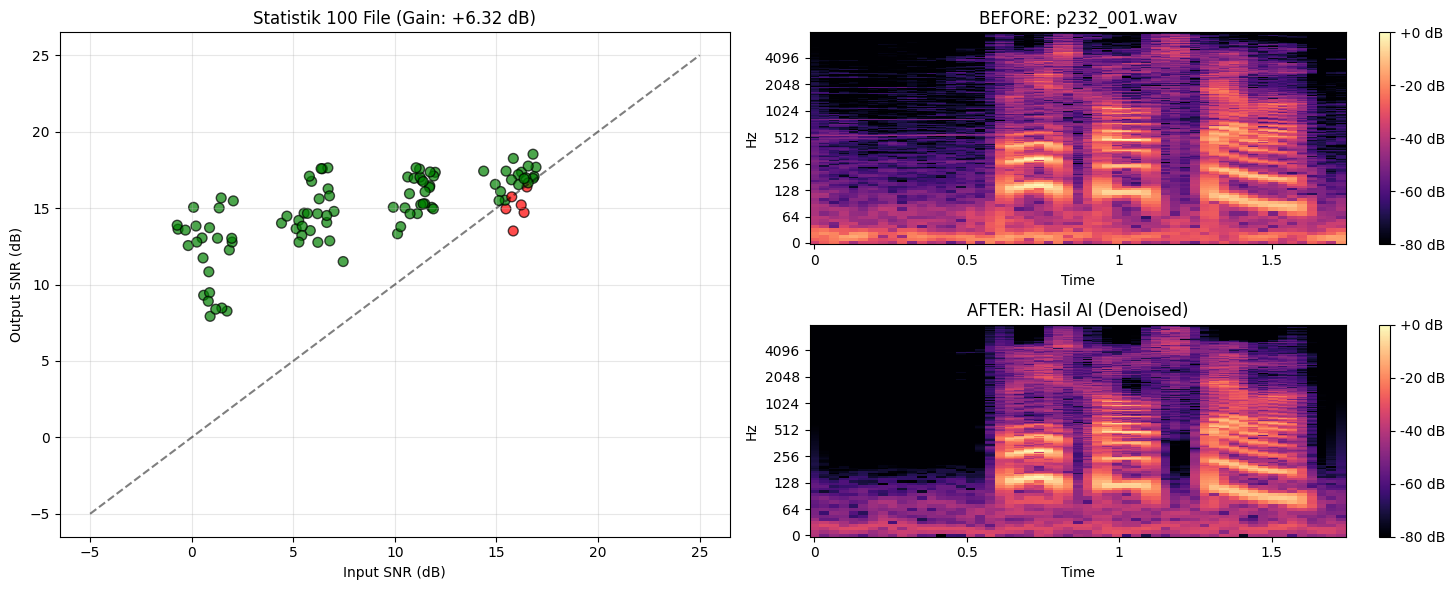


🎧 DEMO AUDIO: p232_001.wav
1. 🔴 Input (Noisy):



2. 🟢 Output (AI):



3. 🔵 Reference (Clean):


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

# --- 1. SETUP & CARI FOLDER ---
local_extract_path = '/content/data_raw'
test_clean_path = None
test_noisy_path = None

for root, dirs, files in os.walk(local_extract_path):
    for d in dirs:
        if 'clean_testset' in d: test_clean_path = os.path.join(root, d)
        elif 'noisy_testset' in d: test_noisy_path = os.path.join(root, d)

def calculate_snr(clean, reconstructed):
    min_len = min(len(clean), len(reconstructed))
    clean = clean[:min_len]
    reconstructed = reconstructed[:min_len]
    noise_residual = clean - reconstructed
    power_clean = np.sum(clean ** 2)
    power_noise = np.sum(noise_residual ** 2)
    if power_noise == 0: return 100
    return 10 * np.log10(power_clean / power_noise)

# --- 2. PROSES 100 FILE ---
if test_clean_path and test_noisy_path:

    # === BAGIAN SORTED ===
    # Kita ambil semua file, lalu urutkan abjad (A-Z) biar konsisten
    all_files = sorted([f for f in os.listdir(test_noisy_path) if f.endswith('.wav')])
    # Ambil 100 file pertama yang sudah urut
    test_files = all_files[:100]
    # ==============================

    snr_in, snr_out = [], []
    demo_data = {}

    print(f"Sedang memproses {len(test_files)} file secara URUT ABJAD...")

    for i, f in enumerate(tqdm(test_files)):
        try:
            # Load
            y_noisy, sr = librosa.load(os.path.join(test_noisy_path, f), sr=16000)
            y_clean, _ = librosa.load(os.path.join(test_clean_path, f), sr=16000)

            #STFT
            S = librosa.stft(y_noisy, n_fft=512, hop_length=256)

            # AI Inference

            pred_mag = flexible_model.predict(np.expand_dims(np.abs(S).T, 0), verbose=0)[0].T
            y_denoised = librosa.istft(pred_mag * np.exp(1j * np.angle(S)), hop_length=256)

            # Hitung Skor
            s_in = calculate_snr(y_clean, y_noisy)
            s_out = calculate_snr(y_clean, y_denoised)
            snr_in.append(s_in); snr_out.append(s_out)

            # Simpan file pertama (index 0) buat demo
            if i == 0:
                demo_data = {
                    'name': f, 'y_noisy': y_noisy, 'y_clean': y_clean,
                    'y_denoised': y_denoised, 'sr': sr, 'gain': s_out - s_in
                }
        except: continue

    avg_gain = np.mean(snr_out) - np.mean(snr_in)

    # --- 3. OUTPUT 1: SCATTER PLOT ---
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot([-5, 25], [-5, 25], 'k--', alpha=0.5)
    colors = ['green' if o > i else 'red' for i, o in zip(snr_in, snr_out)]
    plt.scatter(snr_in, snr_out, c=colors, s=50, alpha=0.7, edgecolors='k')
    plt.title(f'Statistik 100 File (Gain: +{avg_gain:.2f} dB)')
    plt.xlabel('Input SNR (dB)'); plt.ylabel('Output SNR (dB)')
    plt.grid(True, alpha=0.3)

    # --- 4. OUTPUT 2: SPEKTROGRAM ---
    # Atas (Noisy)
    plt.subplot(2, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(demo_data['y_noisy'])), ref=np.max),
                             y_axis='log', x_axis='time', sr=16000, cmap='magma')
    plt.title(f"BEFORE: {demo_data['name']}")
    plt.colorbar(format='%+2.0f dB')

    # Bawah (Cleaned)
    plt.subplot(2, 2, 4)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(demo_data['y_denoised'])), ref=np.max),
                             y_axis='log', x_axis='time', sr=16000, cmap='magma')
    plt.title(f"AFTER: Hasil AI (Denoised)")
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    # --- 5. OUTPUT 3: AUDIO PLAYER ---
    print("\n" + "="*50)
    print(f"🎧 DEMO AUDIO: {demo_data['name']}")
    print("="*50)
    print("1. 🔴 Input (Noisy):")
    ipd.display(ipd.Audio(demo_data['y_noisy'], rate=demo_data['sr']))

    print("\n2. 🟢 Output (AI):")
    ipd.display(ipd.Audio(demo_data['y_denoised'], rate=demo_data['sr']))

    print("\n3. 🔵 Reference (Clean):")
    ipd.display(ipd.Audio(demo_data['y_clean'], rate=demo_data['sr']))

else:
    print("❌ Data tidak ditemukan. Jalankan script Ekstrak dulu.")

REAL-TIME DEMO (GRADIO)

In [ ]:
import gradio as gr
import librosa
import numpy as np
import matplotlib.pyplot as plt

# --- 1. FUNGSI PEMROSESAN (BACKEND) ---
def process_audio_live(audio_filepath):
    if audio_filepath is None:
        return None, None, None

    # A. Load Audio (Paksa ke 16000 Hz biar model ga error)
    # Gradio ngasih path file sementara
    y_noisy, sr = librosa.load(audio_filepath, sr=16000)

    # B. AI Inference (Bersih-bersih)
    # STFT
    S = librosa.stft(y_noisy, n_fft=512, hop_length=256)
    S_mag = np.abs(S).T
    S_phase = np.angle(S)

    # Predict
    X_input = np.expand_dims(S_mag, axis=0)
    pred_mag = flexible_model.predict(X_input, verbose=0)[0].T

    # Reconstruct
    y_clean = librosa.istft(pred_mag * np.exp(1j * S_phase), hop_length=256)

    # C. Bikin Spektrogram (Visual)
    fig = plt.figure(figsize=(10, 6))

    # Gambar Atas: Noisy
    plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_noisy)), ref=np.max),
                             y_axis='log', x_axis='time', sr=16000, cmap='magma')
    plt.title("Suara Masukan (Noisy)")
    plt.colorbar(format='%+2.0f dB')

    # Gambar Bawah: Clean
    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_clean)), ref=np.max),
                             y_axis='log', x_axis='time', sr=16000, cmap='magma')
    plt.title("Hasil AI (Clean)")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

    # Return 3 hal: Audio Asli, Audio Baru, Gambar
    return (16000, y_noisy), (16000, y_clean), fig

# --- 2. DESAIN TAMPILAN (FRONT-END) ---
interface = gr.Interface(
    fn=process_audio_live, # Fungsi otaknya
    inputs=gr.Audio(sources=["microphone", "upload"], type="filepath", label="🎤 Rekam Suara Kamu / Upload File"),
    outputs=[
        gr.Audio(label="🔊 Audio Asli (Noisy)"),
        gr.Audio(label="✨ Audio Hasil AI (Clean)"),
        gr.Plot(label="📊 Analisis Spektrogram")
    ],
    title="🎙️ Demo Real-Time Speech Enhancement",
    description="Coba rekam suara kamu sendiri (misal: nyalakan kipas angin di dekat mic) untuk menguji kecerdasan AI dalam memisahkan noise.",
    theme="default"
)

# --- 3. LUNCURKAN! ---
print("🚀 Sedang menyiapkan website demo...")
interface.launch(share=True, debug=True)

🚀 Sedang menyiapkan website demo...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://aa7c5d69f53d1f345f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:688: UserWarning: Trying to convert audio automatically from float32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


DEMO (FILE UPLOAD)

🎤 SIAPKAN FILE REKAMAN KAMU...
Tips: Rekam suara kamu ngobrol di dekat kipas angin/suara jalanan biar kerasa bedanya.


Saving WhatsApp Audio 2025-11-28 at 21.20.35_b63faa9b.dat.m4a to WhatsApp Audio 2025-11-28 at 21.20.35_b63faa9b.dat.m4a

🔄 Sedang memproses: WhatsApp Audio 2025-11-28 at 21.20.35_b63faa9b.dat.m4a ...


/tmp/ipython-input-4206921130.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  y_noisy, sr = librosa.load(f_name, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


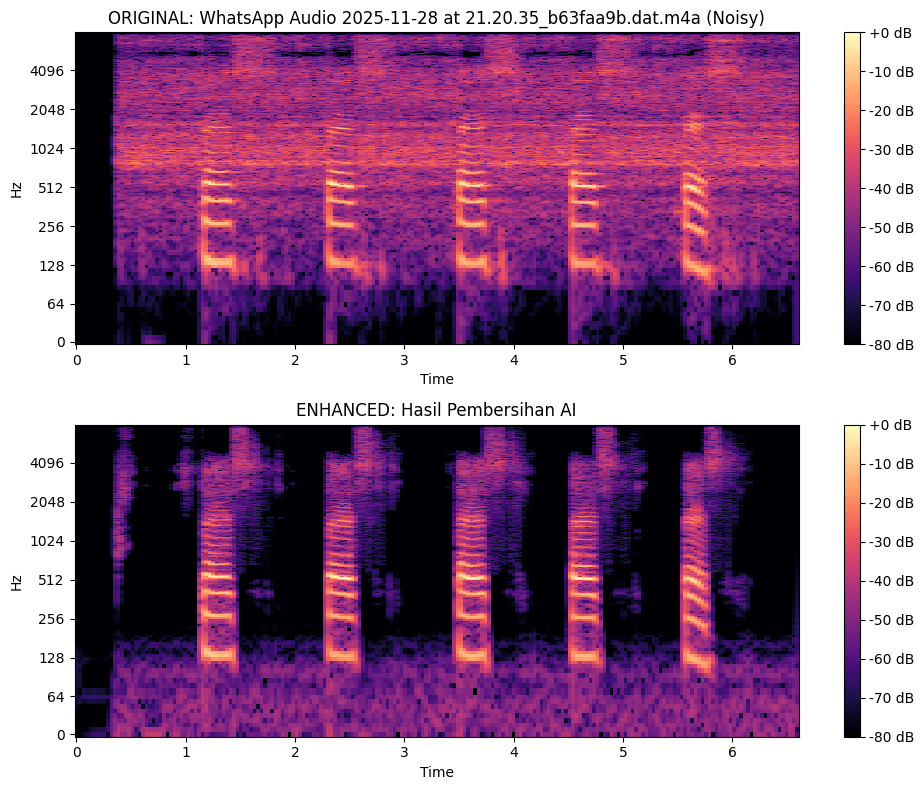

🎧 DENGARKAN BEDANYA:
1. 🔴 Suara Asli (WhatsApp Audio 2025-11-28 at 21.20.35_b63faa9b.dat.m4a):



2. 🟢 Hasil AI (Denoised):


----------------------------------------


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from google.colab import files

print("🎤 SIAPKAN FILE REKAMAN KAMU...")
print("Tips: Rekam suara kamu ngobrol di dekat kipas angin/suara jalanan biar kerasa bedanya.")

# 1. TOMBOL UPLOAD
uploaded = files.upload()

# 2. PROSES SEMUA FILE YANG DI-UPLOAD
for f_name in uploaded.keys():
    print(f"\n🔄 Sedang memproses: {f_name} ...")

    try:
        # A. Load Audio (Paksa convert ke 16kHz biar cocok sama model)
        y_noisy, sr = librosa.load(f_name, sr=16000)

        # B. AI Magic (Inference)
        # STFT
        S = librosa.stft(y_noisy, n_fft=512, hop_length=256)
        S_mag = np.abs(S).T
        S_phase = np.angle(S)

        # Masuk ke Otak Model
        X_input = np.expand_dims(S_mag, axis=0)
        pred_mag = flexible_model.predict(X_input, verbose=0)[0].T

        # Balikin jadi suara (ISTFT)
        y_denoised = librosa.istft(pred_mag * np.exp(1j * S_phase), hop_length=256)

        # C. TAMPILKAN HASIL (VISUAL SPEKTROGRAM)
        plt.figure(figsize=(10, 8))

        # Gambar Atas: ASLI (KOTOR)
        plt.subplot(2, 1, 1)
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_noisy)), ref=np.max),
                                 y_axis='log', x_axis='time', sr=16000, cmap='magma')
        plt.title(f"ORIGINAL: {f_name} (Noisy)")
        plt.colorbar(format='%+2.0f dB')

        # Gambar Bawah: HASIL AI (BERSIH)
        plt.subplot(2, 1, 2)
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_denoised)), ref=np.max),
                                 y_axis='log', x_axis='time', sr=16000, cmap='magma')
        plt.title(f"ENHANCED: Hasil Pembersihan AI")
        plt.colorbar(format='%+2.0f dB')

        plt.tight_layout()
        plt.show()

        # D. PEMUTAR SUARA (AUDIO PLAYER)
        print("="*40)
        print("🎧 DENGARKAN BEDANYA:")
        print("="*40)

        print(f"1. 🔴 Suara Asli ({f_name}):")
        ipd.display(ipd.Audio(y_noisy, rate=sr))

        print("\n2. 🟢 Hasil AI (Denoised):")
        ipd.display(ipd.Audio(y_denoised, rate=sr))
        print("-" * 40)

    except Exception as e:
        print(f"❌ Gagal memproses {f_name}. Pastikan file audio valid (.wav/.mp3).")
        print(f"Error: {e}")

OBJECTIVE EVALUATION (SNR)

In [ ]:
import numpy as np

# 1. Hitung Rata-rata dari data yang sudah ada
rata_input = np.mean(snr_in)   # Rata-rata sebelum masuk AI
rata_output = np.mean(snr_out) # Rata-rata sesudah masuk AI
kenaikan = rata_output - rata_input # Selisihnya (Gain)

# 2. Tampilkan Hasilnya
print("=== INI ANGKA BUAT TABEL KAMU ===")
print(f"1. SNR Awal (Input)  : {rata_input:.2f} dB")
print(f"2. SNR Akhir (Output): {rata_output:.2f} dB")
print(f"3. Peningkatan (Gain): +{kenaikan:.2f} dB")